In [1]:
import tensorflow as tf 
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import numpy as np
import tensorflow as tf
import math


def merge(images, size):
    # Extract the height and width dimensions of the images
    h, w = images.shape[1], images.shape[2]

    # Check if the images have 3 or 4 color channels (RGB or RGBA)
    if (images.shape[3] in (3, 4)):
        # Set the number of color channels
        c = images.shape[3]  # size = 8 X 8 for 64 batch size

        # Create an empty image grid with the specified size
        img = np.zeros((h * size[0], w * size[1], c))

        # Iterate over the images and place each image in the grid
        for idx, image in enumerate(images):
            i = idx % size[1]  # Calculate the column index of the grid
            j = idx // size[1]  # Calculate the row index of the grid
            img[j * h:j * h + h, i * w:i * w + w, :] = image

        # Return the merged image grid
        return img

    # If the images have a single color channel
    elif images.shape[3] == 1:
        # Create an empty image grid without color channels
        img = np.zeros((h * size[0], w * size[1]))

        # Iterate over the images and place each image in the grid
        for idx, image in enumerate(images):
            i = idx % size[1]  # Calculate the column index of the grid
            j = idx // size[1]  # Calculate the row index of the grid
            img[j * h:j * h + h, i * w:i * w + w] = image[:, :, 0]

        # Return the merged image grid
        return img

def image_manifold_size(num_images):
    # Calculate the height and width dimensions of the image grid
    manifold_h = int(np.floor(np.sqrt(num_images)))  # Rounded down square root of num_images
    manifold_w = int(np.ceil(np.sqrt(num_images)))  # Rounded up square root of num_images

    # Ensure that the product of height and width is equal to num_images
    assert manifold_h * manifold_w == num_images

    # Return the calculated dimensions of the image grid
    return manifold_h, manifold_w

def layout_point(final_pred, output_height, output_width):
    # Reshape the final_pred tensor to shape [64, 128, 2]
    bbox_pred = tf.reshape(final_pred, [64, 128, 2])

    # Create a tensor with values ranging from 0 to output_width - 1
    x_r = tf.reshape(tf.range(output_width, dtype=tf.float32),
                     [1, output_width, 1, 1])
    x_r = tf.reshape(tf.tile(x_r, [1, 1, output_width, 1]), [
                     1, output_width * output_width, 1, 1])
    x_r = tf.tile(x_r, [64, 1, 128, 1])

    # Create a tensor with values ranging from 0 to output_height - 1
    y_r = tf.reshape(tf.range(output_height, dtype=tf.float32), [
                     1, 1, output_height, 1])
    y_r = tf.reshape(tf.tile(y_r, [1, output_height, 1, 1]), [
                     1, output_height * output_height, 1, 1])
    y_r = tf.tile(y_r, [64, 1, 128, 1])

    # Extract the x-coordinates from bbox_pred and scale them
    x_pred = tf.reshape(
        tf.slice(bbox_pred, [0, 0, 0], [-1, -1, 1]), [64, 1, 128, 1])
    x_pred = tf.tile(x_pred, [1, output_width * output_width, 1, 1])
    x_pred = (output_width - 1.0) * x_pred

    # Extract the y-coordinates from bbox_pred and scale them
    y_pred = tf.reshape(
        tf.slice(bbox_pred, [0, 0, 1], [-1, -1, 1]), [64, 1, 128, 1])
    y_pred = tf.tile(y_pred, [1, output_height * output_height, 1, 1])
    y_pred = (output_height - 1.0) * y_pred

    # Calculate the difference between x_r and x_pred, and clamp it between 0 and 1
    x_diff = tf.maximum(0.0, 1.0 - tf.abs(x_r - x_pred))

    # Calculate the difference between y_r and y_pred, and clamp it between 0 and 1
    y_diff = tf.maximum(0.0, 1.0 - tf.abs(y_r - y_pred))

    # Calculate the element-wise product of x_diff and y_diff
    xy_diff = x_diff * y_diff

    # Perform max pooling on xy_diff with a kernel size of [1, 1, 128, 1] and strides [1, 1, 1, 1]
    xy_max = tf.nn.max_pool(xy_diff, ksize=[1, 1, 128, 1], strides=[
                            1, 1, 1, 1], padding='VALID')

    # Reshape the resulting tensor to [64, output_height, output_width, 1]
    xy_max = tf.reshape(xy_max, [64, output_height, output_width, 1])

    # Return the final result
    return xy_max

In [3]:
import os
import time
import math
from glob import glob
import tensorflow as tf
import numpy as np
import random
#from mnist_utils import *
import matplotlib.pyplot as plt


class RelationModule(tf.keras.Model):
    def __init__(self, channels=128, output_dim=128, key_dim=128, **kwargs):
        super(RelationModule, self).__init__(**kwargs)
        self.key_dim = key_dim  # Dimension of the key feature
        self.output_dim = output_dim  # Dimension of the output feature
        self.channels = channels  # Number of channels in the input

        # Define the convolutional layers
        self.key = tf.keras.layers.Conv2D(
            output_dim, (1, 1), strides=(1, 1), padding='valid')  # Key convolutional layer
        self.query = tf.keras.layers.Conv2D(
            key_dim, (1, 1), strides=(1, 1), padding='valid')  # Query convolutional layer
        self.value = tf.keras.layers.Conv2D(
            key_dim, (1, 1), strides=(1, 1), padding='valid')  # Value convolutional layer
        self.projection = tf.keras.layers.Conv2D(
            channels, (1, 1), strides=(1, 1), padding='valid')  # Projection convolutional layer

    def call(self, inputs):
        # Reshape inputs to match the shape expected by the convolutional layers
        f_k = tf.reshape(self.key(inputs), [
                        inputs.shape[0], inputs.shape[1]*inputs.shape[2], self.key_dim])
        f_q = tf.reshape(self.query(inputs), [
                        inputs.shape[0], inputs.shape[1]*inputs.shape[2], self.key_dim])

        # Transpose f_q to perform matrix multiplication
        f_q = tf.transpose(f_q, perm=[0, 2, 1])

        # Reshape the value inputs
        f_v = tf.reshape(self.value(inputs), [
                        inputs.shape[0], inputs.shape[1]*inputs.shape[2], self.output_dim])

        # Compute attention weight using matrix multiplication and scaling
        attention_weight = tf.matmul(
            f_k, f_q)/math.sqrt(inputs.shape[1]*inputs.shape[2])

        # Apply attention weights to the value inputs
        out = tf.matmul(tf.transpose(attention_weight, perm=[0, 2, 1]), f_v)

        # Reshape the output tensor
        out = tf.reshape(
            out, [inputs.shape[0], inputs.shape[1], inputs.shape[2], self.output_dim])

        # Apply projection convolutional layer to the output tensor
        out = self.projection(out)

        # Return the output tensor
        return out



class Discriminator(tf.keras.Model):
    def __init__(self, n_filters=32, n_hidden=128, layout_dim=(28, 28), render=layout_point, **kwargs):
        super(Discriminator, self).__init__(**kwargs)
        
        # Initialize the discriminator with the provided parameters
        self.layout_dim = layout_dim
        self.render = render
        self.act = tf.keras.layers.LeakyReLU()
        
        # Define the convolutional layers
        self.conv1 = tf.keras.layers.Conv2D(
            n_filters, (5, 5), input_shape=layout_dim, strides=(2, 2), padding='valid')
        self.bn1 = tf.keras.layers.BatchNormalization()

        self.conv2 = tf.keras.layers.Conv2D(
            n_filters*2, (5, 5), strides=(2, 2), padding='valid')
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.bn3 = tf.keras.layers.BatchNormalization()

        # Flatten the feature maps
        self.flatten = tf.keras.layers.Flatten()
        
        # Define the fully connected layers
        self.fc1 = tf.keras.layers.Dense(512)
        self.bn4 = tf.keras.layers.BatchNormalization()
        self.fc2 = tf.keras.layers.Dense(1)

    def call(self, inputs):
        # Render the inputs using the specified layout dimensions
        x = self.render(inputs, self.layout_dim[0], self.layout_dim[1])
        
        # Apply the activation, convolution, and batch normalization operations
        x = self.act(self.bn1(self.conv1(x)))
        x = self.act(self.bn2(self.conv2(x)))
        
        # Flatten the feature maps
        x = self.flatten(x)
        
        # Apply the activation, fully connected, and batch normalization operations
        x = self.act(self.bn4(self.fc1(x)))
        
        # Generate the discriminator output
        out = self.fc2(x)
        
        # Return the output tensor
        return out


class Generator(tf.keras.Model):
    def __init__(self, n_filters=128, output_dim=2, n_component=128, n_class=1, include_probability=False, **kwargs):
        super(Generator, self).__init__(**kwargs)
        
        # Initialize the Generator with the provided parameters
        self.n_filters = n_filters
        self.output_dim = output_dim
        self.n_component = n_component
        self.n_class = n_class
        self.include_probability = include_probability

        self.act = tf.keras.layers.ReLU()
        
        # Define the first set of convolutional layers
        self.conv1_1 = tf.keras.layers.Conv2D(n_filters, (1, 1), input_shape=(
            self.n_component, self.n_class, self.output_dim), strides=(1, 1), padding='valid')
        self.bn1_1 = tf.keras.layers.BatchNormalization()
        self.conv1_2 = tf.keras.layers.Conv2D(
            n_filters//4, (1, 1), strides=(1, 1), padding='valid')
        self.bn1_2 = tf.keras.layers.BatchNormalization()
        self.conv1_3 = tf.keras.layers.Conv2D(
            n_filters//4, (1, 1), strides=(1, 1), padding='valid')
        self.bn1_3 = tf.keras.layers.BatchNormalization()
        self.conv1_4 = tf.keras.layers.Conv2D(
            n_filters, (1, 1), strides=(1, 1), padding='valid')
        self.bn1_4 = tf.keras.layers.BatchNormalization()

        # Define the relation modules
        self.relation1 = RelationModule(
            channels=n_class*n_filters, output_dim=n_filters, key_dim=n_filters)
        self.relation2 = RelationModule(
            channels=n_class*n_filters, output_dim=n_filters, key_dim=n_filters)
        self.bn_x1 = tf.keras.layers.BatchNormalization()
        self.bn_x2 = tf.keras.layers.BatchNormalization()
        self.bn_x3 = tf.keras.layers.BatchNormalization()
        self.bn_x4 = tf.keras.layers.BatchNormalization()

        # Define the second set of convolutional layers
        self.conv2_1 = tf.keras.layers.Conv2D(
            n_filters, (1, 1), strides=(1, 1), padding='valid')
        self.bn2_1 = tf.keras.layers.BatchNormalization()
        self.conv2_2 = tf.keras.layers.Conv2D(
            n_filters//4, (1, 1), strides=(1, 1), padding='valid')
        self.bn2_2 = tf.keras.layers.BatchNormalization()
        self.conv2_3 = tf.keras.layers.Conv2D(
            n_filters//4, (1, 1), strides=(1, 1), padding='valid')
        self.bn2_3 = tf.keras.layers.BatchNormalization()
        self.conv2_4 = tf.keras.layers.Conv2D(
            n_filters, (1, 1), strides=(1, 1), padding='valid')
        self.bn2_4 = tf.keras.layers.BatchNormalization()
        
        # Define the final geometric parameter output layer
        self.geometric_param = tf.keras.layers.Conv2D(
            output_dim, (1, 1), strides=(1, 1), padding='valid')
        
        # Define the final class score output layer
        self.class_score = tf.keras.layers.Conv2D(
            n_class, (1, 1), strides=(1, 1), padding='valid')

    def call(self, x):
        x = tf.reshape(x, [x.shape[0], self.n_component,
                       self.n_class, self.output_dim])
        
        # Pass input through the first set of convolutional layers
        h1_0 = self.bn1_1(self.conv1_1(x))
        h1_1 = self.act(self.bn1_2(self.conv1_2(x)))
        h1_2 = self.act(self.bn1_3(self.conv1_3(h1_1)))
        h1_3 = self.act(self.bn1_4(self.conv1_4(h1_2)))

        # Combine the outputs of the first set of layers
        embedding = self.act(tf.add(h1_0, h1_3))
        embedding = tf.reshape(
            embedding, [x.shape[0], self.n_component, 1, -1])

        # Pass the embedding through the relation modules
        context = self.act(self.bn_x2(
            tf.add(embedding, self.bn_x1(self.relation1(embedding)))))
        context = self.act(self.bn_x4(
            tf.add(context, self.bn_x3(self.relation2(context)))))

        # Pass the context through the second set of convolutional layers
        h2_0 = self.bn2_1(self.conv2_1(context))
        h2_1 = self.act(self.bn2_2(self.conv2_2(h2_0)))
        h2_2 = self.act(self.bn2_3(self.conv2_3(h2_1)))
        h2_3 = self.act(self.bn2_4(self.conv2_4(h2_2)))

        # Combine the outputs of the second set of layers
        decoded = self.act(tf.add(h2_0, h2_3))
        out = self.geometric_param(decoded)
        out = tf.sigmoid(tf.reshape(
            out, [-1, self.n_component, self.output_dim]))

        # Add class score and probability if multiple classes are present
        if(self.n_class > 1):
            cls_score = self.class_score(decoded)
            cls_prob = tf.sigmoid(tf.reshape(
                cls_score, [-1, self.n_component, self.n_class]))
            out = tf.concat([out, cls_prob], axis=-1)

        return out


c:\conda_temp/ipykernel_2608/1620466511.py:117: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  samples[img_ind, :, :]).astype(np.int)


[Sample] d_loss: 1.57420373, g_loss: 0.80555606
Epoch: [ 0] [   8/1093] time: 7.8579, d_loss: 1.5308, g_loss: 0.7539
[Sample] d_loss: 1.53612506, g_loss: 0.77451146
Epoch: [ 0] [  18/1093] time: 11.6708, d_loss: 1.5533, g_loss: 0.7333
[Sample] d_loss: 1.54320896, g_loss: 0.81375784
Epoch: [ 0] [  28/1093] time: 15.5957, d_loss: 1.5270, g_loss: 0.7561
[Sample] d_loss: 1.51309288, g_loss: 0.79589760
Epoch: [ 0] [  38/1093] time: 19.4485, d_loss: 1.4945, g_loss: 0.7605
[Sample] d_loss: 1.49149323, g_loss: 0.78128874
Epoch: [ 0] [  48/1093] time: 23.3102, d_loss: 1.4937, g_loss: 0.7344
[Sample] d_loss: 1.50405943, g_loss: 0.77403218
Epoch: [ 0] [  58/1093] time: 27.1590, d_loss: 1.4827, g_loss: 0.7280
[Sample] d_loss: 1.47901988, g_loss: 0.75979155
Epoch: [ 0] [  68/1093] time: 31.0113, d_loss: 1.4800, g_loss: 0.7386
[Sample] d_loss: 1.46684599, g_loss: 0.73672330
Epoch: [ 0] [  78/1093] time: 34.9234, d_loss: 1.4739, g_loss: 0.7253
[Sample] d_loss: 1.47104228, g_loss: 0.73887879
Epoch: [ 

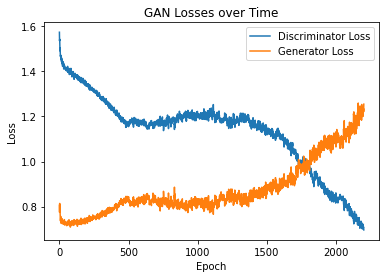

In [4]:
import os
import time
import math
from glob import glob
import tensorflow as tf
import numpy as np
import random
#from mnist_utils import *
#from mnist_modules import *
import matplotlib.pyplot as plt
import PIL
from PIL import Image
from PIL import ImageFont, ImageDraw
from PIL import Image

import matplotlib.pyplot as plt

def plot_losses(d_losses, g_losses):
    # Calculate the number of epochs based on the discriminator losses
    epochs = len(d_losses)
    
    # Plot the discriminator losses over epochs
    plt.plot(range(epochs), d_losses, label='Discriminator Loss')
    
    # Plot the generator losses over epochs
    plt.plot(range(epochs), g_losses, label='Generator Loss')
    
    # Set the label for the x-axis as "Epoch"
    plt.xlabel('Epoch')
    
    # Set the label for the y-axis as "Loss"
    plt.ylabel('Loss')
    
    # Set the title of the plot
    plt.title('GAN Losses over Time')
    
    # Display a legend for the plot
    plt.legend()
    
    # Show the plot
    plt.show()

class LayoutGAN(object):
    def __init__(self, geometric_dim=2, n_class=1, batch_size=64, n_component=128, layout_dim=(28, 28), d_lr=1e-5, g_lr=1.e-5, update_ratio=2, clip_value=0.08568, dataset_name='default', dataset_path='./data/pre_data_cls.npy', checkpoint_dir=None, sample_dir=None):
        # Initialize the LayoutGAN object with the given parameters
        self.batch_size = batch_size  # Batch size for training
        self.n_component = n_component  # Number of components
        self.n_class = n_class  # Number of classes
        self.geometric_dim = geometric_dim  # Dimensionality of geometric space
        self.layout_dim = layout_dim  # Dimensionality of the layout
        self.dataset_name = dataset_name  # Name of the dataset
        self.checkpoint_dir = checkpoint_dir  # Directory to save checkpoints
        self.data = np.load(dataset_path)  # Load the dataset from the specified path
        self.build_model(d_lr, g_lr)  # Build the generator and discriminator models
        self.sample_dir = sample_dir  # Directory to save generated samples
        self.update_ratio = update_ratio  # Update ratio for generator and discriminator training
        self.clip_value = clip_value  # Clip value for discriminator weights during training
        epoch_step = len(self.data) // self.batch_size  # Number of steps per epoch
        dlr = tf.keras.optimizers.schedules.ExponentialDecay(
            1e-5, epoch_step*10, 0.1, staircase=True, name=None)  # Learning rate schedule for the discriminator

    def build_model(self, dlr, g_lr):
        self.G = self.build_generator()  # Build the generator model
        self.D = self.build_discriminator()  # Build the discriminator model
        self.d_opt = tf.keras.optimizers.Adam(dlr)  # Adam optimizer for the discriminator
        self.g_opt = tf.keras.optimizers.Adam(g_lr)  # Adam optimizer for the generator


    def step(self, real_data, noise, training=True):
        with tf.GradientTape() as disc_tape:
            disc_loss = self.discriminator_loss(real_data, noise)  # Compute the discriminator loss

        if(training):
            gradients_of_discriminator = disc_tape.gradient(
                disc_loss, self.D.trainable_variables)  # Compute the gradients of discriminator variables
            self.d_opt.apply_gradients(
                zip(gradients_of_discriminator, self.D.trainable_variables))  # Apply gradients to update discriminator weights

        for i in range(2):
            with tf.GradientTape() as gen_tape:
                gen_loss = self.generator_loss(noise)  # Compute the generator loss

            if(training):
                gradients_of_generator = gen_tape.gradient(
                    gen_loss, self.G.trainable_variables)  # Compute the gradients of generator variables
                self.g_opt.apply_gradients(
                    zip(gradients_of_generator, self.G.trainable_variables))  # Apply gradients to update generator weights

        return gen_loss, disc_loss


    def train(self):
        # Calculate the number of steps per epoch
        epoch_step = len(self.data) // self.batch_size
        
        # Select a sample from the dataset
        sample = self.data[0:self.batch_size]
        sample_inputs = np.array(sample).astype(np.float32)
        sample_inputs = sample_inputs * 28.0 / 27.0
        
        # Generate random noise for the sample
        sample_z = np.random.normal(
            0.5, 0.13, (self.batch_size, self.n_component, self.n_class, self.geometric_dim))
        
        # Initialize counters and lists
        counter = 1
        start_time = time.time()
        d_losses = []
        g_losses = []
        epochs = 50
        # Main training loop
        for epoch in range(epochs):
            np.random.shuffle(self.data)
            batch_idxs = len(self.data) // self.batch_size

            for idx in range(0, batch_idxs):
                # Select a batch of images
                batch = self.data[idx*self.batch_size:(idx+1)*self.batch_size]
                batch_images = np.array(batch).astype(np.float32)

                # Preprocess batch images
                batch_images = batch_images * 28.0 / 27.0
                
                # Generate random noise for the batch
                batch_z = np.random.normal(
                    0.5, 0.13, (self.batch_size, self.n_component, self.n_class, self.geometric_dim))
                
                # Perform one step of training
                g_loss, d_loss = self.step(batch_images, batch_z)
                counter += 1
                
                # Print progress and losses every 10 steps
                if np.mod(counter, 10) == 0:
                    print("Epoch: [%2d] [%4d/%4d] time: %4.4f, d_loss: %.4f, g_loss: %.4f"
                          % (epoch, idx, batch_idxs, time.time()-start_time, d_loss, g_loss))

                # Generate and save samples every 1 step
                if np.mod(counter, 1) == 0:

                # Generate samples using the generator network
                    samples = self.G(sample_z)
                
                # Perform a forward pass through the discriminator and generator networks
                    g_loss, d_loss = self.step(sample_inputs, sample_z, training=False)
                
                # Reshape the generated samples
                    samples = np.reshape(samples, (64, 128, 2))

                    # Scale the samples to the desired range
                    samples = 27.0 * samples

                    # Create an empty image array to store the rendered layouts
                    img_all = np.zeros((64, self.layout_dim[0], self.layout_dim[1], 3), dtype=np.uint8)

                    # Render the layouts for each sample
                    rendered_layout = self.D.render(samples, self.layout_dim[0], self.layout_dim[1])

                    # Create a list to store individual images
                    img_list = []

                    # Process each sample individually
                    for img_ind in range(64):
                        # Extract the points from the sample
                        pointset = np.rint(samples[img_ind, :, :]).astype(np.int)

                        # Remove rows with all zero values
                        pointset = pointset[~(pointset == 0).all(1)]

                        # Create an empty image
                        img = np.zeros((28, 28), dtype=np.float32)

                        # Set the corresponding points to white (255)
                        img[pointset[:, 0], pointset[:, 1]] = 255

                        # Normalize the image and convert to grayscale
                        img_list.append(img/255)
                        img = Image.fromarray(img.astype('uint8'), 'L')

                        # Convert the grayscale image to RGB and store in the image array
                        img_all[img_ind, :, :, :] = np.array(img.convert('RGB'))

                    # Merge the individual images into a single image grid
                    img_all = np.squeeze(merge(img_all, image_manifold_size(samples.shape[0])))

                    # Save the generated image
                    plt.imsave('{}/train_{:02d}_{:04d}.jpg'.format(self.sample_dir, epoch, idx), np.array(img_all, dtype=np.uint8))

                    # Print the losses every 10 steps
                    if idx % 10 == 0:
                        print("[Sample] d_loss: %.8f, g_loss: %.8f" % (d_loss, g_loss))
                        d_losses.append(d_loss)
                        g_losses.append(g_loss)

        # Plot the losses
        plot_losses(d_losses, g_losses)

    def render(self):
    # Placeholder function, currently does nothing
        pass

    def build_discriminator(self):
        # Build and return the discriminator network
        return Discriminator(layout_dim=self.layout_dim, render=layout_point)

    def build_generator(self):
        # Build and return the generator network
        return Generator(n_filters=512, output_dim=self.geometric_dim, n_component=self.n_component, n_class=self.n_class)

    def gradient_penalty(self, real, fake):
        # Calculate the gradient penalty term for the WGAN-GP loss
        alpha = tf.random.uniform(shape=[real.shape[0], 1, 1], minval=0.0, maxval=1.)
        
        # Interpolate between real and fake samples
        interpolated = alpha * real + (1 - alpha) * fake
        
        with tf.GradientTape() as tape_p:
            # Watch the interpolated samples for gradient calculation
            tape_p.watch(interpolated)
            
            # Compute the discriminator output logits for interpolated samples
            logit = self.D(interpolated)

        # Compute the gradient of the logits with respect to the interpolated samples
        grad = tape_p.gradient(logit, interpolated)
        
        # Compute the L2 norm of the gradients
        grad_norm = tf.norm(tf.reshape(grad, (real.shape[0], -1)), axis=1)
        
        # Compute the gradient penalty term as the squared difference between the norm and 1
        return 10 * tf.reduce_mean(tf.square(grad_norm - 1.))


    def generator_loss(self, z):
        # Generate samples using the generator
        x = self.G(z, training=True)
        
        # Compute the discriminator output logits for the generated samples
        fake_score = self.D(x, training=True)
        
        # Compute the generator loss using the sigmoid cross-entropy loss
        g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
            logits=fake_score, labels=tf.ones_like(tf.sigmoid(fake_score))))
        
        return g_loss


    def discriminator_loss(self, x, z):
        # Generate samples using the generator
        x_fake = self.G(z, training=True)
        
        # Compute the discriminator output logits for the real and generated samples
        true_score = self.D(x, training=True)
        fake_score = self.D(x_fake, training=True)
        
        # Compute the discriminator loss using the sigmoid cross-entropy loss
        d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
            logits=true_score, labels=tf.ones_like(tf.sigmoid(true_score))))
        d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
            logits=fake_score, labels=tf.zeros_like(tf.sigmoid(fake_score))))
        
        # Compute the total discriminator loss as the sum of real and fake losses
        d_loss = d_loss_real + d_loss_fake
        
        return d_loss
batch_size = 64
n_component = 128
n_class = 1
geometric_dim = 2

# Specify the directory path to save the generated samples
sample_dir = "C:/Users/jay rana/downloads/samples/Mnist3"

# Create an instance of the LayoutGAN class with the specified parameters
gan = LayoutGAN(
    batch_size=batch_size,
    n_component=n_component,
    n_class=n_class,
    geometric_dim=geometric_dim,
    sample_dir=sample_dir,
    dataset_path="C:/Users/jay rana/downloads/data/MNIST.npy")
# Start the training process
gan.train()
